<a href="https://colab.research.google.com/github/zniihgnexy/DL_code/blob/main/05_RNN_xinyi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

A Recurrent Neural Network (RNN) is a specific type of architecture that is widely used to deal with sequential information. So far, the introduced CNN architectures from the previous tutorials treated inputs as independent objects, however, many applications need to deal with data that is interconnected. For instance, if you are translating a sentence from English to Taiwanese, and you are predicting the next word, it is useful to know which words came before the last one.

RNNs are called recurrent since they apply the same operation to each of the input sequences, with the output of an individual element being dependent on the previous one. Theoretically, RNNs establish a connection between the actual input and ALL the previous ones. Although this is assumed, in the practice, RNNs have proven to only *remember* a limited number of inputs. In other words, RNNs have a *memory* that allows them to *remember* previous elements and use their information to deal with the current input.

RNNs can be split into multiple types depending on their applications. For instance, if we want to predict one word given only the previous one, the topology of our network is a *One to One*. Another example is image captioning, where we can design a *One to Many* architecture to obtain a description from a single input image. The following diagram shows the different types of problems we can face ([Source](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)):


![alt text](http://karpathy.github.io/assets/rnn/diags.jpeg)

**A Closer Look to RNN**

The figure below shows the simplest version of an RNN, which can be easily derived from a simple feedforward architecture by adding a single loop:

![alt text](https://i.ibb.co/qnGH6RT/vanilla-rnn.png)

During training, the hidden state $h$ is iteratively updated based on the input value $x$ and the learned weights $W_h$ and $W_x$. The final output $y$ is estimated from the current state $h_t$ and the matrix $W_y$.

Although RNN can assure short-term dependencies within the network, simple RNNs become unable to learn to connect information as the gap between past and present information grows. To overcome this limitation, in practical applications LSTM unit is adopted, that is a special RNNs architecture composed of multiple interacting layers ([Source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)):
![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)



In this tutorial, we will use LSTMs straight away as a black box.

# ***Many to One* RNNs - Regression**

In this section, we are going to implement an easy example of an RNN in Keras. Given the records of a local newspaper, which indicates the number of new subscriptions per month, we want to predict the number of members that will join next month.

First, we load the data with the utility method in Pandas `read_csv`, which allows us to load directly the dataset from an URL address. Let's print some rows of the imported record to see the format of the data.

In [3]:
# install ktrain first due to some dependencies needed for the transformer sec.
!pip install ktrain
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
import io
import requests
data=pd.read_csv("https://drive.google.com/uc?id=1Hv2nuwVXO_aZN89llGva0hSH6k3kKAVm",usecols=[1],engine = "python")
data.head()

,Number of subscriptions to city newspaper
0,112
1,118
2,132
3,129
4,121


Moreover, let's plot the number of subscriptions per month.

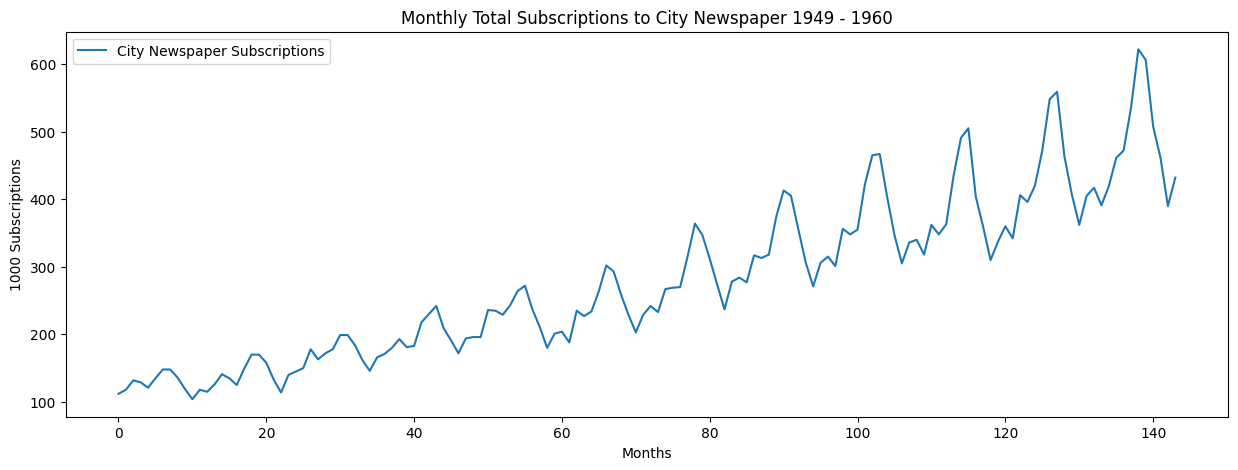

In [4]:
plt.figure(figsize = (15, 5))
plt.plot(data, label = "City Newspaper Subscriptions")
plt.xlabel("Months")
plt.ylabel("1000 Subscriptions")
plt.title("Monthly Total Subscriptions to City Newspaper 1949 - 1960")
plt.legend()
plt.show()

Now we are ready to start importing Keras' modules.

In [10]:
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

First of all, we need to prepare the data for the training and test stage. Once the data is loaded, we normalize the input values and split them between training (70%) and testing (30%).


In [11]:
# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 100
Number of samples test set: 44


We also arrange the dataset (input and labels) in the appropriate Keras' format by using the helper function `create_dataset()`.

`create_dataset()` takes as argument the variable `window_size`. This variable is highly important when dealing with sequences since it is going to determine the length of our input data to the network. For instance, by setting `window_size` to 5, we will be using the last 5 monthly subscriptions values to predict the next one.

In [12]:
# helper function to read data.
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

# Create test and training sets for regression with window size 5.
window_size = 5
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))

Shape of training inputs: (94, 5, 1)
Shape of training labels: (94,)


Once all the data is ready, we create the model as a `Sequential` object including 16 LSTM units and a dense layer outputting a single scalar.
As mentioned, we specify a window size equal to 5, so that the prediction of the current element depends only on the previous five ones.

In [13]:
batch_size = 32
rnn = Sequential()
rnn.add(LSTM(16, input_shape = (window_size, 1)))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = "adam", metrics = ['mse'])

rnn.fit(train_X, train_Y, epochs=500, batch_size=batch_size, verbose=0)

Now we can compute the MSE on the training and test data:

In [14]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return score, pred

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

2/2 [==============================] - 0s 31ms/step
Training data error: 27.27 MSE
Test data error: 56.08 MSE


Moreover, we can plot the predictions and actual values in a graph to check visually the performance of our predictor.

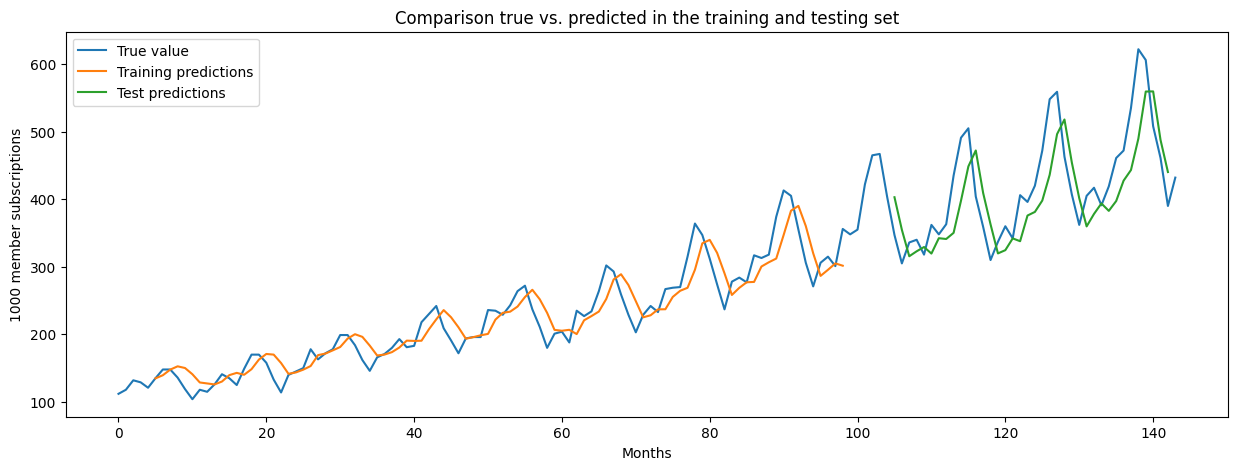

In [15]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")
plt.plot(train_predictions, label = "Training predictions")
plt.plot(test_predictions, label = "Test predictions")
plt.xlabel("Months")
plt.ylabel("1000 member subscriptions")
plt.title("Comparison true vs. predicted in the training and testing set")
plt.legend()
plt.show()

#Sequence Modelling: Text

Now we will use RNNs to tackle text examples. Text is one of the modalities that have been widely tackled with deep learning improving upon past methods. We will present two problems: classification and generation.

A small summary of both problems is given below.

**Classification**

Classification is a standard problem, where we have some input data $x$ and try to classify it as one of the available classes $y$. In the case of sequential data, though, $x$ will be a sequence of elements that will be processed by the RNN to return the label $y$. The image depicts a sequence classification problem, where the red blocks are inputs, the green blocks the RNN model, and the blue block is the output. An example of a text classification problem that can be tackled with RNNs is "Hate speech detection", where the architecture must identify if an input text contains racist or sexist language, among others.

![alt text](https://i.ibb.co/TtZPpZr/Capture.jpg)


**Generation**

In a generation problem, we aim to generate a sequence $y$ following the same distribution as the real data $x$. We will input the sequence into the model, and we will output another sequence $y$. Text translation is a typical example of many to many RNNs.

![](https://i.ibb.co/7gSwnT2/Capture.jpg)



## Preliminary imports

Here we include some of the used imports during the tutorial. Just run it to import the necessary modules.

In [16]:
## These are just a bunch of imports
## Just run them
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, Add, Lambda
from keras.layers import LSTM
from keras.datasets import imdb

from keras import __version__
from keras import backend as K


import numpy as np
import matplotlib.pyplot as plt

# Text Classification

**References:**

https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb#scrollTo=BYu8ql1nG7xc

For the text classification example we will use the IMDB dataset available in Keras. The dataset includes tens of thousands of movie reviews taken from the IMDB website with a corresponding label for each review. The label is binary, and indicates if the review has a positive (label=1) or negative (label=0) sentiment. This problem is a quite standard Natural Language Processing (NLP) problem, and it is called sentiment classification or sentiment analysis.

Before loading the data and building our model, we will explain a common part of NLP models, the embeddings.

### Embeddings
**References:**

[1] https://nlp.stanford.edu/projects/glove/

[2] https://colab.research.google.com/drive/1oXjNYSJ3VsRvAsXN4ClmtsVEgPW_CX_c?hl=en#scrollTo=p9q7qfXrvq-J


Usually, the first step of text modelling is transforming the words into a numerical vector that represents the meaning or some properties of the word. This vector can be then processed by the network. To do so, we first will encode the word sequences in integer numbers, and we will also have a dictionary that contains the relationship `(actual word, integer)`. For example, the sentence "the cat is on the table and the dog is on the mat" can be encoded in the form $(7, 1, 3, 5, 7, 6, 0, 7, 2, 3, 5, 7, 4)$, with the corresponding dictionary $(and, 0), (cat, 1), (dog, 2)\dots (the, 7)$:

In [17]:
sentence = 'the cat is on the table and the dog is on the mat'
## We form a list of unique words by using a set
## which returns only unique elements
## we also sort them, which is not necessary
sentence_set = sorted(set(sentence.split(' ')))
words = list(sentence_set)
## We now form a dictionary in the form of
## e.g. dict_words[and] = 1
dict_words = dict((word, i) for i, word in enumerate(words))
## We now encode the sentence in a list of integers
encoded_sentence = [dict_words[w] for w in sentence.split()]
print(sentence_set)
print(encoded_sentence)
print(dict_words)

['and', 'cat', 'dog', 'is', 'mat', 'on', 'table', 'the']
[7, 1, 3, 5, 7, 6, 0, 7, 2, 3, 5, 7, 4]
{'and': 0, 'cat': 1, 'dog': 2, 'is': 3, 'mat': 4, 'on': 5, 'table': 6, 'the': 7}


Keras contains a class called `Tokenizer` that helps in performing this process. We will not use it for the examples in this tutorial, as we want to show all the steps involved in the tokenization process, but the `Tokenizer` class provides a high-level way to handle this preprocessing step. As it can be quite useful, we provide a small overview of it. [Here](https://keras.io/preprocessing/text/) you have a link to the Keras documentation explaining the different arguments of the class.

In [18]:
import keras
## First you define a tokenizer object
## If you want a character level tokenization we set char_level=True
## If set to false, it will tokenize in a word level
## You can check in the documentation the different arguments
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False)
## Then you fit it on the data you have
## The method expects a list of sentences
tokenizer.fit_on_texts([sentence])

In [19]:
## Now, the class has formed a dictionary with all the words
print(tokenizer.word_index)

{'the': 1, 'is': 2, 'on': 3, 'cat': 4, 'table': 5, 'and': 6, 'dog': 7, 'mat': 8}


In [20]:
## You can also check the word count
print(tokenizer.word_counts)

OrderedDict([('the', 4), ('cat', 1), ('is', 2), ('on', 2), ('table', 1), ('and', 1), ('dog', 1), ('mat', 1)])


In [21]:
## You can transform the data to sequences of integers
## We print the first 10 elements
tokenizer.texts_to_sequences([sentence])

[[1, 4, 2, 3, 1, 5, 6, 1, 7, 2, 3, 1, 8]]

Now that we have the sequence in the form of a list of integers,  we could input that directly to the RNN. However, as those numbers are arbitraryly chosen, it would be really hard for the RNN to understand the relationships between the words. To give the model more representation power, we first want to transform the integer to a vector of dimension $d$ which represents the semantic meaning of the words. Each of these vectors is called an Embedding. The actual values of the vectors are not important, only the relationships between them. For example, `dog` and `cat` vectors are probably going to be closer than `dog` and `the`. Or if you are doing sentiment classification, probably two words encoding similar positive sentiments will be closer than a word expressing positive sentiments and a completely neutral word.

 The embeddings can be initialized randomly and the model will learn suitable values to reduce the loss during the training process. However, embeddings which have already been trained in a large corpus of text such as Wikipedia can also be used. Examples of these pretrained embeddings are [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) or  [GloVe](https://nlp.stanford.edu/projects/glove/). These methods are trained using the context of the words, for example predicting the surrounding words when a specific word is given. As a result, words that appear in similar contexts have closer embeddings.

![alt text](https://i.ibb.co/s5sg6dZ/Screenshot-from-2019-02-08-15-13-41.png)

The image shows relationships between words in the embedding space.



We now download the GloVe pretrained vectors trained in Wikipedia and Gigaword. [Here](https://nlp.stanford.edu/projects/glove/) you have an overview of what GloVe is. We will see how the embeddings contain a semantic meaning that allows us to model semantic relationships.

In [22]:
## Download and unzip glove pretrained embeddings
!wget https://imperialcollegelondon.box.com/shared/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt -O gensim_glove_vectors.txt

--2024-02-02 10:55:35--  https://imperialcollegelondon.box.com/shared/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 74.112.186.144
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt [following]
--2024-02-02 10:55:35--  https://imperialcollegelondon.box.com/public/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt [following]
--2024-02-02 10:55:35--  https://imperialcollegelondon.app.box.com/public/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.

We will now load the GloVe embeddings. We use `gensim` to manipulate the embeddings, which is a nice tool that can be used to play with GloVe or Word2Vec embeddings. This piece of code takes some time to load, as the embeddings file is quite large.

In [23]:
## We load the embeddings
## Gensim is a really useful module that provides high-level function
## to use with the embeddings
!pip install gensim
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

Now we will do some operations using the embeddings of the words. First, we will do some words arithmetics based on the embeddings, which it will show us that the words encode some semantic meaning. For example, the distance between words with similar semantic meaning but different genders is approximately fixed. Meaning that the vector resulting from doing $man - woman$ should be similar to $king - queen$, hence:

$king - queen \approx man - woman \rightarrow woman + king - man \approx queen$

We can check this using the method `most_similar` and the `positive` and `negative` arguments as following:



In [24]:
## We can do word arithmetics.
## We look for the nearest neighbour of the vector resulting on doing
## the operation 'king' + 'woman' - 'man'
glove_model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6713277101516724),
 ('princess', 0.5432624816894531),
 ('throne', 0.5386103987693787),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.49802514910697937),
 ('mother', 0.49564430117607117),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747090458869934),
 ('prince', 0.4668239951133728),
 ('wife', 0.46473270654678345)]

In [25]:
## Similar examples
glove_model.most_similar(positive=['google', 'ios'], negative=['apple'])

[('android', 0.5720318555831909),
 ('apps', 0.5662358999252319),
 ('app', 0.5322650074958801),
 ('facebook', 0.4770543873310089),
 ('smartphones', 0.47069063782691956),
 ('gmail', 0.46772605180740356),
 ('firefox', 0.4666401743888855),
 ('skype', 0.4491073787212372),
 ('iphone', 0.44582632184028625),
 ('web-based', 0.44464385509490967)]

In [26]:
glove_model.most_similar(positive=['england', 'paris'], negative=['france'])

[('london', 0.6710129976272583),
 ('manchester', 0.5267473459243774),
 ('birmingham', 0.493479460477829),
 ('liverpool', 0.4903382360935211),
 ('oxford', 0.4811282157897949),
 ('middlesex', 0.47516533732414246),
 ('surrey', 0.46148523688316345),
 ('sussex', 0.45899879932403564),
 ('leeds', 0.4551934599876404),
 ('essex', 0.45398277044296265)]

In [27]:
## We can also check the word that does not match the rest
glove_model.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

To check out other functions you can call use [this](https://radimrehurek.com/gensim/models/keyedvectors.html#module-gensim.models.keyedvectors).


In http://projector.tensorflow.org/ you can visualize the words projected in the $\mathbb{R}^3$ space using either PCA or tSNE, which are both techniques for dimensionality reduction. There, you can see how words are clustered by meaning or topic.


![](https://brenndoerfer.github.io/deep-sentiment-analysis-distill/img/tensorboard_projector.gif)

Image taken from [here](https://brenndoerfer.github.io/deep-sentiment-analysis-distill/index.html)

### IMDB
Now let's start tackling a text classification problem. We first load the IMDB dataset for sentiment classification. As we said, it contains movie reviews with a corresponding binary sentiment label (label=1 corresponds to positive sentiment, and label=0 to negative sentiment). The words are already encoded as integers in order from most common words to less common (e.g. `the` is a common word so it should be encoded as a small integer). That makes it easy to filter the non-common words by using the argument `num_words` when loading the data. The filtered words will be all encoded as a special token `<UNK>`, which means unknown. For example, if we want to load the dataset with only the top $5000$ most common words we can do this:

In [28]:
# number of most-frequent words to use
nb_words = 5000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
x_train: (25000,)
x_test: (25000,)


We see that the dataset contains 25000 examples for both train and testing. Let's print an example.

In [29]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


The printed example is a sequence of numbers. It is important to note that there are three special integers in this IMDB dataset: $0$, $1$ and $2$. $0$ will be used to pad the sequences, which we will explain now. $1$ is used as the `<START>` token (you can see how the printed sequence starts with a `1`). $2$ is the token `<UNK>` which is used for all the filtered non-common words. If we want to retrieve the actual sentence, we can use the dictionary given when using the method `get_word_index()`. However, the given dictionary when calling `get_word_index()` does not take into account the three mentioned tokens, so we need to modify it a little bit.

In [30]:
# get_word_index retrieves a mapping word -> index
word_index = imdb.get_word_index()
# We make space for the three special tokens
word_index_c = dict((w, i+3) for (w, i) in word_index.items())
word_index_c['<PAD>'] = 0
word_index_c['<START>'] = 1
word_index_c['<UNK>'] = 2
# Instead of having dictionary word -> index we form
# the dictionary index -> word
index_word = dict((i, w) for (w, i) in word_index_c.items())
# We now retrieve the sentence
sentence = ''
for index in x_train[0]:
  sentence += index_word[index] + ' '
print(sentence)
print(y_train[0])

1641221/1641221 [==============================] - 0s 0us/step
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film b

We can see how we just recovered the sentence that we had printed before as a sequence of numbers. We can also see how there is no punctuation in this dataset. The review is clearly positive, so the corresponding label is "1".

One of the problems with the given text data is that the sequences all have a different length. We want to give Keras a batch of inputs with fixed dimensions. To do so, we define a maximum length `maxlen`, and truncate the sentences longer than that, and also pad with $0$'s at the beginning the sentences shorter than that length. We use the method `sequence.pad_sequence` from `keras.preprocessing`

In [31]:
# Truncate sentences after this number of words
maxlen = 80
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


We can check how some sentences are padded at the beginning to be of length `maxlen`.

In [32]:
x_train[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    1,  778,  128,   74,   12,  630,  163,
         15,    4, 1766,    2, 1051,    2,   32,   85,  156,   45,   40,
        148,  139,  121,  664,  665,   10,   10, 1361,  173,    4,  749,
          2,   16, 3804,    8,    4,  226,   65,   12,   43,  127,   24,
          2,   10,   10], dtype=int32)

We will now build the model we will use for sentiment classification. The model is formed by an Embedding layer, where the model will learn a vector of dimensionality `embedding_dim` for each of the words; an LSTM layer and a linear layer that maps the output of the LSTM to 1 value. We train this with the `binary_crossentropy` loss and `sigmoid` activation as we only have two classes.

In [33]:
## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300
## LSTM dimensionality
lstm_units = 128

print('Build model...')
text_class_model = Sequential()

text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen))

text_class_model.add(LSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
# model.add(LSTM(lstm_units, return_sequences=True))
# model.add(LSTM(lstm_units))


# You can add some dropout if you want
# model.add(Dropout(0.5))

text_class_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(text_class_model.summary())

Build model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 300)           1500000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1719777 (6.56 MB)
Trainable params: 1719777 (6.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Let's train it for 5 epochs.

In [34]:
## We train the model for 5 epochs and check the accuracy in a validation split
epochs = 5
validation_split = 0.2

history = text_class_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, validation_split=validation_split)


Epoch 1/5
157/157 [==============================] - 24s 129ms/step - loss: 0.4554 - accuracy: 0.7776 - val_loss: 0.3780 - val_accuracy: 0.8298
Epoch 2/5
157/157 [==============================] - 8s 51ms/step - loss: 0.3066 - accuracy: 0.8708 - val_loss: 0.3636 - val_accuracy: 0.8316
Epoch 3/5
157/157 [==============================] - 4s 29ms/step - loss: 0.2449 - accuracy: 0.9006 - val_loss: 0.3894 - val_accuracy: 0.8288
Epoch 4/5
157/157 [==============================] - 4s 25ms/step - loss: 0.2049 - accuracy: 0.9186 - val_loss: 0.5542 - val_accuracy: 0.8214
Epoch 5/5
157/157 [==============================] - 3s 20ms/step - loss: 0.1673 - accuracy: 0.9348 - val_loss: 0.4987 - val_accuracy: 0.8174


This is a classification example, so let's print the loss and the classification accuracy.

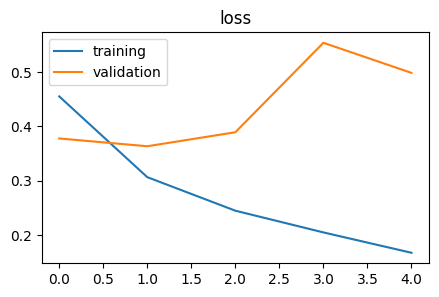

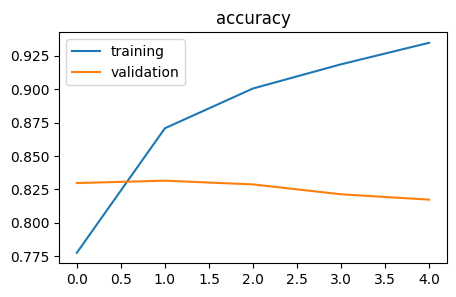

In [35]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'], label='training')
plt.plot(history.epoch,history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

It looks like we could have stopped the training earlier as the validation loss did not decrease afterwards.

In [36]:
# Let's see the accuracy in the test split
scores = text_class_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

782/782 - 4s - loss: 0.5142 - accuracy: 0.8184 - 4s/epoch - 5ms/step
accuracy: 81.84%


### Saving best performing model

Now we save the best performing models using the validation loss as a metric. As you already know, lower training error does not mean in some cases better performance in the validation or test split.

In the last example we ran the model for 5 epochs, however after the first epoch the validation loss increased. We want to use the model performing the best in the validation set. To do so, we can use a ModelCheckpoint callback as was explained in past tutorials.

In [37]:
###### We reset the model #######
text_class_model = Sequential()
text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen))
text_class_model.add(LSTM(lstm_units))
text_class_model.add(Dense(1, activation='sigmoid'))
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#################################


from keras.callbacks import ModelCheckpoint
## Here we define the checkpoint callback. We first give the name it will use
## to save the model. We also specify what metric should monitor, in this case
## the validation loss (it could be validation accuracy too for example)
## save_best_only means that the models will only be save when the monitored
## metric improves with respect to the past best one
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1,
                             monitor='val_loss', save_best_only=True)
## Now we pass the callback to the fit method
history = text_class_model.fit(x_train, y_train, batch_size=128,
                               epochs=epochs, callbacks=[checkpoint],
                               validation_split=validation_split)



Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7706
Epoch 1: val_loss improved from inf to 0.37845, saving model to model-001.h5
157/157 [==============================] - 22s 107ms/step - loss: 0.4589 - accuracy: 0.7706 - val_loss: 0.3785 - val_accuracy: 0.8316
Epoch 2/5
  2/157 [..............................] - ETA: 15s - loss: 0.3000 - accuracy: 0.8984

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8686
Epoch 2: val_loss improved from 0.37845 to 0.36725, saving model to model-002.h5
157/157 [==============================] - 6s 36ms/step - loss: 0.3133 - accuracy: 0.8686 - val_loss: 0.3672 - val_accuracy: 0.8364
Epoch 3/5
157/157 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9003
Epoch 3: val_loss did not improve from 0.36725
157/157 [==============================] - 5s 32ms/step - loss: 0.2452 - accuracy: 0.9003 - val_loss: 0.3872 - val_accuracy: 0.8320
Epoch 4/5
157/157 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9234
Epoch 4: val_loss did not improve from 0.36725
157/157 [==============================] - 5s 32ms/step - loss: 0.1999 - accuracy: 0.9234 - val_loss: 0.4513 - val_accuracy: 0.8182
Epoch 5/5
157/157 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9409
Epoch 5: val_loss did not improve from 0.36725
157/157 [===

We now saved the model after every epoch if the validation loss decreased. In this case, as the best epoch is the first one, it only saves the model after the first epoch. Let's load the model now.

In [38]:
from keras.models import load_model
text_class_model = load_model('model-001.h5')  # load model weights

And now we check if the accuracy is better compared to when we used the model trained for 5 epochs.

In [39]:
# Let's see the accuracy in the test split
scores = text_class_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

782/782 - 4s - loss: 0.3728 - accuracy: 0.8336 - 4s/epoch - 5ms/step
accuracy: 83.36%


### Importance of embeddings
Now, let's check quickly if using Embeddings provide any benefit. For this experiment, we remove the Embedding layer, meaning we will be inputting the word index, i.e. an integer, to the LSTM. Additionally, we need to vary the shape of the input data as the LSTM needs a third dimension with the number of channels per input (in this case 1, as each word is represented by an integer).

In [40]:
# model parameters
# Same model as before but without embeddings
lstm_units = 128
x_train_r = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test_r = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


print('Build model...')
text_class_model = Sequential()

text_class_model.add(LSTM(lstm_units, input_shape=(maxlen, 1)))

text_class_model.add(Dense(1, activation='sigmoid'))

text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(text_class_model.summary())

Build model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [41]:
epochs = 5
validation_split = 0.2

history = text_class_model.fit(x_train_r, y_train, batch_size=128,
          epochs=epochs,
          validation_split=validation_split)


Epoch 1/5
157/157 [==============================] - 5s 13ms/step - loss: 0.6933 - accuracy: 0.5179 - val_loss: 0.6894 - val_accuracy: 0.5364
Epoch 2/5
157/157 [==============================] - 1s 8ms/step - loss: 0.6892 - accuracy: 0.5362 - val_loss: 0.6918 - val_accuracy: 0.5390
Epoch 3/5
157/157 [==============================] - 1s 8ms/step - loss: 0.6866 - accuracy: 0.5472 - val_loss: 0.6826 - val_accuracy: 0.5648
Epoch 4/5
157/157 [==============================] - 1s 8ms/step - loss: 0.6847 - accuracy: 0.5501 - val_loss: 0.6789 - val_accuracy: 0.5762
Epoch 5/5
157/157 [==============================] - 1s 8ms/step - loss: 0.6834 - accuracy: 0.5517 - val_loss: 0.6783 - val_accuracy: 0.5750


In [42]:
scores = text_class_model.evaluate(x_test_r, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

782/782 - 3s - loss: 0.6817 - accuracy: 0.5626 - 3s/epoch - 3ms/step
accuracy: 56.26%


We see how the accuracy is just slightly better compared to doing a random guess as there are only 2 classes. That is because the integer that encodes the word is chosen arbitrarily and does not encode any property of the words nor any relationship between words. Hence, using learned embeddings results in models with better capacity/accuracy for this kind of tasks.

Instead of inputting directly integers to the RNN, we could argue that another way of representing the input words is to input the one-hot representation of the word directly to the RNN instead of using embeddings. This method has two problems. First, the resulting dimensionality would be too large. In this case we are loading the $20000$ most common words in IMDB, so each word would be encoded in a vector of dimensionality $20000$. Secondly, the encoding does not give any notion of similarity between the different words. For these two reasons, embedding the words to a common lower dimensionality space is also better than using one-hot encoding.

# Text Generation

We now will present an example of text generation using an RNN. We will use the Tiny Shakespeare dataset, which contains samples from Shakespeare works.

We pose the problem as a classification problem as in the Sentiment classification example. In a text generation setting, given a sequence, we aim to predict the next one. During the training step, the process would be quite similar to the classification task, i.e. given a sequence you predict a label/word/character. However, in the prediction setting, we aim to output a whole sentence, not only a word or character. For that reason we will follow the procedure explained in the image.

![](https://cdn-images-1.medium.com/max/1600/1*XvUt5wDQA8D3C0wAuxAvbA.png)
The image is taken from [here](https://medium.com/@david.campion/text-generation-using-bidirectional-lstm-and-doc2vec-models-1-3-8979eb65cb3a)

As in the text classification section, we encode the raw sentences in the form of a sequence of integers. In this case, however, we have a text with a really wide vocabulary, and we aim to predict the following element of the sequence. In this dataset the number of words is really large, so if we used a word-level model the number of available classes would be quite large if we did not filter the number of possible words. For this example, instead of encoding on a word level, we will do it on a character level, which results in a more limited vocabulary. We aim to predict the next character when inputting a sentence of length $d$. In evaluation mode, i.e. when we are predicting the next character, we then input a seed of $d$ characters as the first input, and afterwards we use the last $d$ characters as input to predict the next character.

The advantages of predicting characters instead of words is that character-level models have a limited vocabulary/classes compared to the number of possible words in a text. They are also more flexible (for example, they can generate "fake" url links if trained in e.g. wikipedia data). However, word-level models usually present higher performance as it easier for them to keep track of the long-term meaning of the sentence, and also can avoid any spelling mistakes that may happen in character-level models.

**References:** Some code snippets taken from [here](https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/)


We first download the data we use for the example, and then read the file.

In [43]:
!wget https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
## We read all the raw data in the variable data
data = open('./tiny-shakespeare.txt', 'r').read()

--2024-02-02 11:29:24--  https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny-shakespeare.txt’

tiny-shakespeare.tx 100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-02-02 11:29:25 (20.4 MB/s) - ‘tiny-shakespeare.txt’ saved [1115394/1115394]



Let's print a subset of the data for visualization purposes.

In [44]:
print(data[:364])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?


We see in the raw text that the name of the characters is printed, that there is a blank line between the different character lines, and also that lines are usually not longer than ~80 characters. We hope the network is capable of learning all of this.

Now we will structure the data so we can input it into our RNN model. We aim to encode the text using a sequence of integers as we explained in the classification section.  Hence, we form a dictionary with all the different characters appearing in the text (including whitespaces and punctuation) and its corresponding integer.

In [45]:
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

Now we want to split the text in examples of length `seq_length` where the label is the next character. As we mentioned, we pose the problem as a set of successive classification problems, where we try to predict the next word given an input sentence. To split the text in pairs of (sequence, next word), we use the dictionary `char_to_n` to encode the different elements as integers.


In [46]:
x = []
y = []
length = len(data)
seq_length = 100
for i in range(0, length-seq_length, 1):
  sequence = data[i:i + seq_length]
  label = data[i + seq_length]
  x.append([char_to_n[char] for char in sequence])
  y.append(char_to_n[label])
n_samples = len(x)
print("Total Samples: {:d}".format(n_samples))

Total Samples: 1115294


We now form a test split by using 5% of the available data. To do so, we just take the last 5% of the data. Usually, you need to randomize the data before splitting in test/train to avoid having a different distribution of the data in both splits. However, as this is a sequential data where we want to predict the next character, if we shuffle the splits we would have this in training:

``
x = 'the boy is tal_' y = 'l'
``

and this in testing:

``
x = 'the boy is ta_' y = 'l'
``

which would contaminate the splits.

In [47]:
import keras
x_train = x[:int(n_samples*0.95)]
x_test = x[int(n_samples*0.95):]
y_train = y[:int(n_samples*0.95)]
y_test = y[int(n_samples*0.95):]

## Transform the list to a numpy array
x_train = np.reshape(x_train, (len(x_train), seq_length))
## Onehot encoding of labels
# 基本就是按照分类读取数据什么的
y_train = tf.keras.utils.to_categorical(np.asarray(y_train))

x_test = np.reshape(x_test, (len(x_test), seq_length))
y_test = tf.keras.utils.to_categorical(np.asarray(y_test))


Let's print a sequence and the shape of the labels.

In [48]:
print(x_train[8000])
print(y_train.shape)

[ 0 13  1 57 47 41 49  1 51 39 52  5 57  1 39 54 54 43 58 47 58 43  6  1
 61 46 53  1 42 43 57 47 56 43 57  1 51 53 57 58  1 58 46 39 58  0 35 46
 47 41 46  1 61 53 59 50 42  1 47 52 41 56 43 39 57 43  1 46 47 57  1 43
 60 47 50  8  1 20 43  1 58 46 39 58  1 42 43 54 43 52 42 57  0 33 54 53
 52  1 63 53]
(1059529, 65)


Here, we define the model.

In [49]:
# define the LSTM model
embedding_size = 100
lstm_units = 128

text_gen_model = Sequential()
text_gen_model.add(Embedding(y_train.shape[1],
                    embedding_size, input_length=seq_length))
text_gen_model.add(LSTM(lstm_units))
text_gen_model.add(Dense(y_train.shape[1], activation='softmax'))

text_gen_model.compile(loss='categorical_crossentropy', optimizer='adam')
text_gen_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          6500      
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 65)                8385      
                                                                 
Total params: 132133 (516.14 KB)
Trainable params: 132133 (516.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model is a little bit complex, so training takes some time.

In [50]:
text_gen_model.fit(x_train, y_train, epochs=10 , batch_size=128)

Epoch 1/10
8278/8278 [==============================] - 82s 10ms/step - loss: 1.9590
Epoch 2/10
8278/8278 [==============================] - 80s 10ms/step - loss: 1.6268
Epoch 3/10
8278/8278 [==============================] - 76s 9ms/step - loss: 1.5398
Epoch 4/10
8278/8278 [==============================] - 94s 11ms/step - loss: 1.4940
Epoch 5/10
8278/8278 [==============================] - 78s 9ms/step - loss: 1.4637
Epoch 6/10
8278/8278 [==============================] - 78s 9ms/step - loss: 1.4418
Epoch 7/10
8278/8278 [==============================] - 79s 10ms/step - loss: 1.4250
Epoch 8/10
8278/8278 [==============================] - 79s 9ms/step - loss: 1.4115
Epoch 9/10
8278/8278 [==============================] - 77s 9ms/step - loss: 1.4006
Epoch 10/10
8278/8278 [==============================] - 78s 9ms/step - loss: 1.3913


### Prediction

We now take any of the sequences from the test split and use it as an initial pattern for our model. Then we enter a loop where given an input sequence, we predict the next character and then form a new input sequence by appending the predicted character and dropping the first character.

Whenever we input a sequence, we obtain as output a probability distribution of the possible characters. For example, given the sequence `the cat and the do` the model will output a probability distribution of the next character where probably the character `g` will have a high probability (forming then `the cat and the dog`). However, the character `c` can also be a possibility, as the sentence formed may be `the cat and the doctor`. When deciding what character to predict, a strategy is to just take the character with the maximum probability at all times, but then the variability of the formed text is then smaller. Another option would be to sample following the same probability of distribution as the model outputs. However, this might result in a excessive variability with some sentences not making any sense.

This trade-off of variability against more probable sequences is controlled by what it is called the temperature of the sampling process. The temperature controls the smoothing of the probability vector. A temperature close to 0 will result in taking always the safest (i.e. that with the highest probability) as the next element. A temperature close to 1 will decide on the next element following the same distribution of probability as the original output of the model.

In a more formal way, being $p_i$ the probability of the element $i$ output by the RNN model and $T$ the temperature, the probability after applying the mentioned smoothing $\hat{p_i}$ is:

$$
\hat{p_i} = \frac{e^{\log(p_i)/T}}{\sum_j e^{\log(p_j)/T}}
$$

You can check how a small $T$ is going to make the element with the largest probability be close to 1 after the process.

Before starting the text prediction, let's show an example of how the sampling temperature affects the model choices.

In [51]:
def temperature_smoothing(prediction, temperature=1.0):
  # This function computes the temperature smoothing function
  # we explained
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  return prediction

# We have this vector of probabilities
prediction = np.asarray([0.2, 0.3, 0.1, 0.4])
## Temperature = 1.0
print('Output probabilities with temp.=1')
print(temperature_smoothing(prediction, temperature=1))
## Temperature = 0.5
print('Output probabilities with temp.=0.5')
print(temperature_smoothing(prediction, temperature=0.5))
## Temperature = 0.25
print('Output probabilities with temp.=0.25')
print(temperature_smoothing(prediction, temperature=0.25))
## Temperature = 0.0
print('Output probabilities with temp.=0')
print(temperature_smoothing(prediction, temperature=0))

Output probabilities with temp.=1
[0.20065194 0.29977201 0.10101691 0.39855913]
Output probabilities with temp.=0.5
[0.13579339 0.30071527 0.03488383 0.5286075 ]
Output probabilities with temp.=0.25
[0.04948661 0.23537565 0.00344097 0.71169677]
Output probabilities with temp.=0
[7.88880627e-31 3.20722891e-13 6.22348202e-61 1.00000000e+00]


You can see how a lower temperature makes the small probabilities become smaller.

Here you can set the temperature and check how the output varies. You will see that for $T\approx0$ the generated text has low variability.

In [56]:
import sys
# Vary the temperature here
temperature = 0.5

# We select a random element from the test set as seed
start = np.random.randint(0, len(x_test)-1)
pattern = x_test[start].tolist()
print("Seed:")
print("\"", ''.join([n_to_char[value] for value in pattern]), "\"")

print("\nPredicted:")
# generate 300 characters
for i in range(300):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = n_to_char[index]
  seq_in = [n_to_char[value] for value in pattern]
  ## Print the result
  sys.stdout.write(result)

  ## Create the input sequence for the next character by appending the predicted
  ## character and dropping the first one to always have constant seq. length
  pattern.append(index)
  pattern = pattern[1:]


Seed:
"  welcome,
While I with self-same kindness welcome thine.
Brother Petruchio, sister Katharina,
And th "

Predicted:
en the father of the sent.

LEONTES:
A honour his face to mine eyes and fear.

GLOUCESTER:
Not our grief of his noble and hatter of the
pity of the hollow most wipper the banished,
I have behold to a complect and head
To the field and countents to his confession.

First Senator:
I have for a true st

Notice how the network has learnt the structure of the text, to start a new line every few words and to put the name of the characters too. The text itself seems grammatically correct in most cases but it fails to make much sense in most examples. Generating sentences with actual semantic meaning is harder for these type of models compared to generating grammatically correct sentences. Test different temperature settings to see how it affects the generation

If you want to know more about text generation, along with some extra generated examples, we refer you to [Andrej Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

### Quantitative evaluation of the generated text

For a quantitative evaluation of the generated text we will use a metric commonly used in image captioning and translation tasks, BLEU. BLEU looks for matches on a word level between the generated text and the reference text. Specifically, BLEU looks for matches in n-grams up to $n=4$, where an n-gram is defined as a contiguous sentence of $n$ items. For example, in the sentence `the sky is blue`, an n-gram of $n=2$ would be `is blue`. BLEU scores range from [0,1].

As we mentioned, BLEU is usual in more constrained text generation tasks, such as image captioning. In our text generation task there is a large number of both grammatically and semantically correct possibilities when generating new sentences, and one of the issues for this task is to develop a metric that can properly evaluate the semantic and syntactic quality of the generated text. Human evaluation is quite common when evaluating the quality of generated sentences in these less constrained tasks due to the difficulty of finding proper automatic metrics. However, we hope to see a correlation between the BLEU score and the quality of the generated text. Here we take an input sentence from the test data and generate a sentence. Then, we compare the generated sentence to the real one from the corpus. We do so 20 times and provide the average BLEU score.

The used function is integrated in the package `nltk` and it is called using the following syntax `sentence_bleu(reference, candidate).`

In [57]:
from nltk.translate.bleu_score import sentence_bleu
import sys
import time
import string
a = time.time()
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}
temperature = 0.5
bleu_score = 0
n_eval = 20
seq_char_length = 100
for _ in range(n_eval):
  start = np.random.randint(0, len(x_test)-seq_char_length-1)
  pattern = x_test[start].tolist()
  reference = x_test[start+seq_char_length].tolist()
  reference = ''.join([n_to_char[value] for value in reference])
  # generate characters
  output_sent = ''
  for n_char in range(seq_char_length):
    x = np.reshape(pattern, (1, len(pattern)))
    prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
    prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    prediction = np.random.multinomial(1, prediction[0,:], 1)
    index = np.argmax(prediction)
    result = n_to_char[index]
    output_sent += result
    pattern.append(index)
    pattern = pattern[1:]
  # We filter the reference and candidate words to remove any punctuation
  # We also use only lower case words
  reference = reference.translate(str.maketrans('', '', string.punctuation)).replace('\n',' ').lower().split(' ')
  # We filter any empty element in the list
  reference = list(filter(lambda x: x is not '', reference))
  candidate = output_sent.replace('\n',' ').translate(str.maketrans('', '', string.punctuation)).lower().split(' ')
  candidate = list(filter(lambda x: x is not '', candidate))
  # We remove the first and the last word for both the reference and candidate
  # because they may not be completed words
  bleu_score += sentence_bleu(reference[1:-1], candidate[1:-1])
print(bleu_score/n_eval)

<>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-57-535e9ee74b2c>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  reference = list(filter(lambda x: x is not '', reference))
<ipython-input-57-535e9ee74b2c>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  candidate = list(filter(lambda x: x is not '', candidate))
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
T

7.41037030161225e-232


# Transformers
RNNs are still quite used in several architectures and Natural Language Processing (NLP) tasks. However, during the last 3 years (since the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) was published) a new architecture, the Transformer, has started to outperform RNNs in several text/NLP benchmarks. A Transformer does not use any recurrence, it instead uses attention to focus on specific parts of a sentence. If you want an in-depth explanation of the architecture, you can take a look to the [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) blog post.

Both text classification and text generation tasks have been succesfully tackled by transformers. Transfomers seem to scale better than recurrent neural networks, they can have great results when using large architectures and large datasets, whereas RNNs seem not to benefit as much from using more parameters and training examples. State-of-the-art transformer models can have even billions of parameters and can benefit from training in TBs of text data.

We will show examples for both text classification and text generation of models pretrained on large datasets. The aim of the examples is to show you how these large models trained in diverse/large datasets can transfer their knowledge to several tasks (similarly to the transfer learning/finetuning section in the CNN Architectures notebook). However, we will not implement any transformer model from scratch. If you are interested in doing so, besides the theoretical explanation of the [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) blog post, you can also check the [transformers example](https://keras.io/examples/nlp/text_classification_with_transformer/) in the Keras docs.



##Text Classification

For the text classification task, the model called BERT from Google, and all the subsequent variants have achieved state-of-the-art results. BERT is a method to train language representations, meaning that you then can use those represenations/embeddings to predict the label of the sentence in a text classification task.

We will now show a quick example of finetuning BERT in IMDB to show you the capabilities of this model. We take part of the code from [this link](https://colab.research.google.com/drive/18SVeIFXWCiA9HL4WVCAFxlfH59ez6atc#scrollTo=IhHGCuPhv5Ew). To run the following piece of code you may need to restart your environment due to some dependencies issues (it will tell you to do so).

In [1]:
# install ktrain
!pip install ktrain==0.26.3
# import ktrain
import ktrain
from ktrain import text

  Using cached ktrain-0.26.3.tar.gz (25.3 MB)
  Preparing metadata (setup.py) ... done
  Using cached scikit-learn-0.23.2.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# download IMDb movie review dataset
# As we take the code from another notebook, the way to load the
# data is different, but the splits are the same as when using imbd.load_data
import tensorflow as tf
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)
# set path to dataset
import os.path
#dataset = '/root/.keras/datasets/aclImdb'
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(IMDB_DATADIR)

84131840/84125825 [==============================] - 1s 0us/step
/root/.keras/datasets/aclImdb


In [ ]:
trn, test, preproc = text.texts_from_folder(IMDB_DATADIR,
                                          maxlen=500,
                                          preprocess_mode='bert',
                                          train_test_names=['train',
                                                            'test'],
                                          classes=['pos', 'neg'])

The code below will load a pretrained BERT model and it will start finetuning it in IMDB. We also provide a model finetuned for IMDB as training for 1 epoch takes 1 hour.

In [ ]:
model = text.text_classifier('bert', trn, preproc=preproc)
learner = ktrain.get_learner(model,train_data=trn, val_data=test, batch_size=6)

Is Multi-Label? False
maxlen is 500
done.


We train for one epoch (you can skip this step as we already provide a trained model).

In [ ]:
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 5547s 1s/step - loss: 0.1335 - accuracy: 0.9528 - val_loss: 0.1641 - val_accuracy: 0.9405


As mentioned, we provide a model already trained. We first download it, load it and test it.

In [ ]:
!wget https://imperialcollegelondon.box.com/shared/static/w4n0r0l8tm2txvvisq64ysgrgvuwrd4h.zip -O bert.zip

In [ ]:
!unzip /content/bert.zip

Archive:  /content/bert.zip
   creating: bert/
  inflating: bert/tf_model.preproc   
  inflating: bert/tf_model.h5        


In [ ]:
# reload Predictor and extract model
model = ktrain.load_predictor('/content/bert').model

# re-instantiate Learner
learner = ktrain.get_learner(model, train_data=trn, val_data=test)

We evaluate now the performance of the loaded model. The model is quite big, so this evaluation step also takes a bit of time.

In [ ]:
learner.evaluate()

KeyboardInterrupt: ignored

The accuracy in the IMDB test set is 94% after finetuning for one epoch, which shows the transferability of the knowledge learned with a large transformer in a large dataset. State-of-the-art results have been achieved in several tasks by transferring the knowledge of BERT and similar models to other NLP dataset/task. Even when using only the resources available via Colab we can get state-of-art results in IMDB with a quick finetuning step.

Let's now predict scores for an example review.

In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc)
predictor.predict_proba('Even though the acting was not superb, the photography was great and the script deserves praise.')

array([0.02212544, 0.9778746 ], dtype=float32)

We can also use the following built-in functionality that allows us to see what words affected the score.

In [ ]:
# To run "explain" you need the following version of the package eli5
!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc)
predictor.explain('Even though the acting was not superb, the photography was great and the script deserves praise.')

## Text Generation

In text generation, the GPT variants from OpenAI have shown impressive results. We will now show an example from a pretrained [GPT2](https://openai.com/blog/better-language-models/) using the [Hugging Face](https://huggingface.co/transformers/index.html#) library, which it contains several state-of-the-art Natural Language Processing (NLP) models. The code to generate text is extracted from this [Colab Notebook](https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb#scrollTo=HBtDOdD0wx3l).

First, we install the Hugging Face library and load a GPT2 pretrained model.

In [ ]:
!pip install ktrain==0.26.3

In [ ]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

Now, we generate text using as input a part of the Tiny Shakespeare dataset. Note that this model has not been finetuned using the Tiny Shakespeare dataset, instead it has been trained in a larger more diverse dataset. You can run the following code to get different outputs.

In [ ]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('First Citizen:\nBefore we proceed any further, hear me speak.\nAll:\nSpeak, speak.\nFirst Citizen:\nYou are all resolved rather to die than to famish?', return_tensors='tf')

# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=200,
    top_k=50
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

What is quite impressive about the output of the GPT model is the capability of matching the style of the input text. The model is not finetuned in our dataset, but it still generates characters names and similary grammar/vocabulary to the given input. This is the result of the large capacity of the model and the diverse training data it used.

Let's try to change the input to a completely different one, using in this case an input from a rugby game.

In [ ]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode("40 mins. Tom Curry receives Stuart Hogg’s kick-off and Youngs kicks poorly to put Scotland back on the attack.\n", return_tensors='tf')

# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=100,
    top_k=50
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

We see how the model understands that the input is related to sports and changes the output style compared to the Tiny Shakespeare example.

We just showed examples with GPT2. However, the newer version of GPT, GPT3, which is trained using a quite larger model and dataset, shows largely improved results.

# Coursework



### **Task 1: RNN Regression**

In this task, you are asked to estimate the next value of a time series. Specifically, we have selected the popular airline passenger dataset. This dataset contains the number of passengers that travels with a certain airline company. The data contains 144 entries, each entry corresponds to the number of the passengers that travel in a given month. The dataset starts in 1949, and it lasts until 1960.

Similarly to the previous example, we import the data and plot it to see the structure.

In [ ]:
import pandas
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import numpy as np

!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
data = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(data)
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("Airline Passengers from January 1949 to December 1960 (12 years)")
plt.show()

# convert pandas data frame in numpy array of float.
data_np = data.values.astype("float32")

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)

# Using 70% of data for training, 30% for test.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

First of all, you need to train an RNN on the airline passenger dataset. This exercise expects you to study the impact of the `window_size` variable when defining the `train` and `test` dataset splits. Remember that the `window_size` variable indicates the number of past observations used for predicting the current value. Here, we treat the `test` split as a validation set.

In [ ]:
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

window_size = 1 #Use this variable to build the dataset with different number of inputs

# Create test and training sets for regression with different window sizes.
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))


**Report**:

*   Create a plot showing the test curves of models trained with different `window_size` values. Report the plot and discuss the main differences you observe between the predicted curves. You can use the style proposed on the Many to One RNNs - Regression section to plot your curves.

### **Task 2: Text Embeddings**
For this task, we tackle a classification problem using the IMDB sentiment dataset as done in the example in the notebook. Labels in IMDB are 0 for negative reviews and 1 for positive reviews. The definitions of the models you will use for this task are given the code below. This task is similar to the transfer learning/finetuning task in the CNN Architectures notebook, however we now test the effect of transfer learning in the embeddings. In this task we use train, validation and test splits with Early Stopping. That means that we will take the best performing model in the validation set and use it in the test set to get a final performance.

**Report**
* Using embeddings of dimensionality 1, train a model without using any LSTM, only using an average pooling of the input embeddings (called `embeddings_model` in the code given below). Then train another model with an LSTM and trainable embeddings initialized at random (called `lstm_model`). Finally train a model with an LSTM with non-trainable embeddings initialized with GloVe embeddings (called `lstm_glove_model`). The code to train the three models is given below. Report in a table the test accuracy obtained after training with the given code for the three models. Also attach in the Appendix the training and validation accuracy curves for the different models trained. You can report the curves after using EarlyStopping with patience 10 (already given in the code), so you don't have to train for the full 50 epochs the three models. Discuss the results.

* Predict the sentiment of the two given example reviews in the code below for the model trained without a LSTM (`embeddings_model`) and for the model trained with a LSTM and GloVe embeddings (`lstm_glove_model`). Report the predictions (you can use the same table as when reporting test accuracies). Discuss the results. Also discuss the differences you can observe between the GloVe embeddings and the embeddings learnt in `embeddings_model` (e.g. what kind of properties the embeddings encode, or differences in the closest words).


We provide the training code you need to use for this exercise below. First we load the dataset as we did in the tutorial. In this exercise, we will use of train, validation and test splits, which are defined in the next cell.


In [ ]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.layers import LSTM, GlobalAvgPool1D
from keras.datasets import imdb
from keras.utils import np_utils

# number of most-frequent words to use
nb_words = 5000
n_classes = 1
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
# get_word_index retrieves a mapping word -> index
word_index = imdb.get_word_index()
# We make space for the three special tokens
word_index_c = dict((w, i+3) for (w, i) in word_index.items())
word_index_c['<PAD>'] = 0
word_index_c['<START>'] = 1
word_index_c['<UNK>'] = 2
# Instead of having dictionary word -> index we form
# the dictionary index -> word
index_word = dict((i, w) for (w, i) in word_index_c.items())
# Truncate sentences after this number of words
maxlen = 100
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_val = x_train[23000:]
y_val = y_train[23000:]
x_train = x_train[:23000]
y_train = y_train[:23000]


The following code includes the model that uses embeddings of size 1 (so each word is only represented by a single digit) and averages them.

In [ ]:
# Dimensions of the embeddings
embedding_dim = 1

print('Build model...')
embeddings_model = Sequential()

embeddings_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                            trainable=True))
embeddings_model.add(GlobalAvgPool1D())
embeddings_model.add(Dense(1, activation='sigmoid'))
embeddings_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(embeddings_model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 1)            5000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5,002
Trainable params: 5,002
Non-trainable params: 0
_________________________________________________________________
None


We use Early Stopping, so the best validation model is then used to compute the result in the test set.

In [ ]:
from keras.callbacks import EarlyStopping

## We train the model for at most 50 epochs
epochs = 50
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = embeddings_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
embeddings_model.evaluate(x_test, y_test)

Now we have `embedding_model` trained. The code below will print the embedding of any `query_word`, which in this case is a single number. We also give you the code to compute the `top_k` closest embeddings to `query_word`. The metric used is the L2 distance.

In [ ]:
weights = embeddings_model.layers[0].get_weights()[0]
query_word = '8'
dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
top_k = 10
print("Embedding value of {:s} is {:f}", query_word, weights[word_index_c[query_word]][0])
print('Most {:d} similar words to {:s}'.format(top_k, query_word))
for k in range(1, top_k+1):
  print("{:d}: {:s}".format(k, index_word[dist[k]]))

The code below gives the prediction for two example reviews we input. Remember that predictions close to 0 refer to a negative review, and predictions close to 1 refer to a positive review.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
negative_review = "the movie is boring and not good"
words = negative_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
negative_review_score = embeddings_model.predict(seq_input)

positive_review = "the movie is good and not boring"
words = positive_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
positive_review_score = embeddings_model.predict(seq_input)

print("The score for the negative review is:", negative_review_score)
print("The score for the positive review is:", positive_review_score)

With the above code, we trained a model that classifies the sentiment of the sentence using the average of all the embeddings, which were only of size 1. Now we will increase the capacity of the embeddings to 300 and will also add a LSTM to process the embeddings. Hence, the model has a much higher capacity.

In [ ]:
## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300

## LSTM dimensionality
lstm_units = 50

print('Build model...')
lstm_model = Sequential()

lstm_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                            trainable=True))
### Do not modify the layers below
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(lstm_units, dropout=0.2))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(lstm_model.summary())

Similarly, we use EarlyStopping for this model.

In [ ]:
from keras.callbacks import EarlyStopping

## We train the model for 50 epochs
epochs = 50
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = lstm_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
lstm_model.evaluate(x_test, y_test)

We just trained a model with a large number of parameters in the IMDB, which is a small dataset.

The last model we train is the same model as the `lstm_model` above, but in this case we use the embeddings from the GloVe method (which were introduced in this notebook) without any finetuning. First, we download them.

In [ ]:
!wget https://imperialcollegelondon.box.com/shared/static/c9trfhhwl9ohje5g3sapu3xk2zoywp3c.txt -O gensim_glove_vectors.txt

Then we load the GloVe embeddings with dimensionality 300 we just downloaded. This takes some time.

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

We now load the pretrained embeddings in a numpy array to then pass it to the Keras Embedding layer. Change the shape of `embedding_matrix` to the corresponding embedding dimensionality you are using.

In [ ]:
import numpy as np
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index_c.items():
    if word in glove_model:
      embedding_vector = glove_model[word]
      if embedding_vector is not None and i < nb_words:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

To initialize the Keras Embedding layer with the embeddings we loaded, we can use the argument `weights=[embedding_matrix]`. Also, to freeze the embeddings during training, we use `trainable=False`.

In [ ]:
from keras.layers.wrappers import Bidirectional
from keras.layers import GlobalMaxPool1D, Flatten, GlobalAvgPool1D, Dropout

## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300

## LSTM dimensionality
lstm_units = 50

print('Build model...')
lstm_glove_model = Sequential()

lstm_glove_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                            trainable=False))
### Do not modify the layers below
lstm_glove_model.add(Dropout(0.2))
lstm_glove_model.add(LSTM(lstm_units, dropout=0.2))
lstm_glove_model.add(Dropout(0.2))
lstm_glove_model.add(Dense(1, activation='sigmoid'))
lstm_glove_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(lstm_glove_model.summary())

In [ ]:
from keras.callbacks import EarlyStopping

## We train the model for 50 epochs
epochs = 50
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = lstm_glove_model.fit(x_train, y_train, batch_size=32, epochs=epochs, callbacks=[early_stop], validation_data=(x_val,y_val))
print('Final test accuracy is:')
lstm_glove_model.evaluate(x_test, y_test)

We can also compute the closest words in the GloVe embeddings to any `query_word` using the code below.

In [ ]:
query_word = '8'
weights = embedding_matrix

dist = ((weights - weights[word_index_c[query_word]])**2).sum(1).argsort()
top_k = 10
print('Most {:d} similar words to {:s}'.format(top_k, query_word))
for k in range(1, top_k+1):
  print("{:d}: {:s}".format(k, index_word[dist[k]]))

We use the same example reviews as for the `embedding_model` case and we compute the predictions using the `lstm_glove_model`.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
negative_review = "the movie is boring and not good"
words = negative_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
negative_review_score = lstm_glove_model.predict(seq_input)

positive_review = "the movie is good and not boring"
words = positive_review.split()
seq_input = [word_index_c[w] for w in words]
seq_input = np.array([seq_input])
seq_input = pad_sequences(seq_input,maxlen=100)
positive_review_score = lstm_glove_model.predict(seq_input)

print(negative_review_score, positive_review_score)

### **Task 3: Text Generation**
In this task we focus on the text generation problem. For this purpose, we will download the scripts of the TV show Game of Thrones and try to generate some text resembling the style of the scripts.


**Report**
* Plot the retrieved BLEU for different temperature values (from 0 to 2 in the x-axis) for both the character-level model and the word-level model. To compute the BLEU score, use a minimum of 20 generated samples per temperature used to reduce variability (you can increase it at the cost of higher computational time for lower variability). Each sample should contain 100 characters for the char-level model or 30 words for the word-level model (the code given uses these parameters by default). Do you see any relationship between the obtained BLEU score and temperature used? If you generate sentences at different temperatures what differences can you observe? Are the generated sentences grammatically correct? Do the generated sentences make sense?

We give below the code needed to download the dataset and to compute the results.

We first download and read the dataset.

In [ ]:
!git clone https://github.com/shekharkoirala/Game_of_Thrones

In [ ]:
data = open('./Game_of_Thrones/Data/final_data.txt', 'r').read()

**Character-level model**

We first include the code to build the character-level dataset.

In [ ]:
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}
x_char = []
y_char = []
length = len(data)
seq_char_length = 100
for i in range(0, length-seq_char_length):
  sequence = data[i:i + seq_char_length]
  label = data[i + seq_char_length]
  x_char.append([char_to_n[char] for char in sequence])
  y_char.append(char_to_n[label])
n_samples = len(x_char)
print ('Total Samples:' , n_samples)

Total Samples: 2474358


The splits used for training are given below, although we already give the model trained.

In [ ]:
import keras
import numpy as np

x_train_char = x_char[:int(n_samples*0.8)]
x_test_char = x_char[int(n_samples*0.8):]
y_train_char = y_char[:int(n_samples*0.8)]
y_test_char = y_char[int(n_samples*0.8):]
## Transform the list to a numpy array
x_train_char = np.reshape(x_train_char, (len(x_train_char), seq_char_length))
## Onehot encoding of labels
y_train_char = tf.keras.utils.to_categorical(np.asarray(y_train_char))

x_test_char = np.reshape(x_test_char, (len(x_test_char), seq_char_length))
y_test_char = tf.keras.utils.to_categorical(np.asarray(y_test_char))

The definition of the model is the one given below. You will not train the model, so this piece of code is only for you to know what kind of model we trained for this task.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
# define the LSTM model
embedding_size = 300
lstm_units = 256

char_gen_model = Sequential()
char_gen_model.add(Embedding(y_train_char.shape[1],
                    embedding_size, input_length=seq_char_length))
char_gen_model.add(LSTM(lstm_units))
char_gen_model.add(Dense(y_train_char.shape[1], activation='softmax'))

char_gen_model.compile(loss='categorical_crossentropy', optimizer='adam')
char_gen_model.summary()

As the training takes a while, we include a saved model that you can load to skip the training step. Use this model to compute your results.

In [ ]:
!wget https://imperialcollegelondon.box.com/shared/static/1ffasfm5bx691allukv4y8n0tglr5c06.h5 -O ./char_model.h5
char_gen_model = keras.models.load_model("./char_model.h5")

The code you need to evaluate the BLEU score is given below. Vary the temperature to the different needed values. It takes around 1 minute in average per temperature if `n_eval` is set to 20.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import sys
import time
import string
a = time.time()
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}
temperature = 1.0
bleu_score = 0
n_eval = 20
seq_char_length = 100
for _ in range(n_eval):
  start = np.random.randint(0, len(x_test_char)-seq_char_length-1)
  pattern = x_test_char[start].tolist()
  reference = x_test_char[start+seq_char_length].tolist()
  reference = ''.join([n_to_char[value] for value in reference])
  # generate characters
  output_sent = ''
  for n_char in range(seq_char_length):
    x = np.reshape(pattern, (1, len(pattern)))
    prediction = char_gen_model.predict(x, verbose=0).astype(np.float64)
    prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    prediction = np.random.multinomial(1, prediction[0,:], 1)
    index = np.argmax(prediction)
    result = n_to_char[index]
    output_sent += result
    pattern.append(index)
    pattern = pattern[1:]
  # We filter the reference and candidate words to remove any punctuation
  # We also use only lower case words
  reference = reference.translate(str.maketrans('', '', string.punctuation)).replace('\n',' ').lower().split(' ')
  # We filter any empty element in the list
  reference = list(filter(lambda x: x is not '', reference))
  candidate = output_sent.replace('\n',' ').translate(str.maketrans('', '', string.punctuation)).lower().split(' ')
  candidate = list(filter(lambda x: x is not '', candidate))
  # We remove the first and the last word for both the reference and candidate
  # because they may not be completed words
  bleu_score += sentence_bleu(reference[1:-1], candidate[1:-1])
print(bleu_score/n_eval)

The code below allows you to generate sentences for different input patterns and different temperature values. You can test how the temperature values affect the quality of the output sentences for the character-level model by generating a few examples.

In [ ]:
import sys
# Change the temperature here
temperature = 0.5
# You can modify the input pattern here.
pattern = [char_to_n[value] for value in list("TYRION pours himself some wine and drinks it down. He pours another glass, and walks back to CERSEI ")]
pattern = pattern[:seq_char_length]
print("\nPredicted:")
# generate 300 characters
for i in range(300):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = char_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = n_to_char[index]
  seq_in = [n_to_char[value] for value in pattern]
  ## Print the result
  sys.stdout.write(result)

  ## Create the input sequence for the next character by appending the predicted
  ## character and dropping the first one to always have constant seq. length
  pattern.append(index)
  pattern = pattern[1:]

**Word-level model**

We now give the code to run the word-level model. The code is similar to the char-level model. The main difference is that we only try to predict the 2000 words most commonly used in the dataset. The reason for this limitation is to limit the size of the output layer and number of input embeddings for memory constraints.

In [ ]:
from collections import Counter
n_words = 2000
# We preprocess the data to separate the punctuation from the words so e.g.
# "sword." and "sword" are not treated as separate words.
# We also use only lower-cased words
data_p = data.replace('.', ' . ').replace(',', ' , ').replace(':', ' : ').replace('?', ' ? ')
data_p = data_p.replace('!', ' !').replace('\n', ' \n ').replace('[', ' [ ').replace(']', ' ] ')
data_p = data_p.replace(')', ' ) ').replace('(', ' ( ').lower().split(' ')
data_p = list(filter(lambda x: x is not '' and x is not ' ', data_p))
common = dict(Counter(data_p).most_common(n_words))
n_to_word = {n:word for n, word in enumerate(common.keys())}
word_to_n = {word:n for n, word in enumerate(common.keys())}
x_word = []
y_word = []
length = len(data_p)
seq_length = 30
for i in range(0, length-seq_length):
  sequence = data_p[i:i + seq_length]
  label = data_p[i + seq_length]
  seq = []
  if label in common:
    for word in sequence:
      if word in word_to_n:
        seq.append(word_to_n[word])
      else:
        # If the word in the input sequence is not from the most common 2000
        # words, we use a special token. We use the same token for all the
        # non-common words.
        seq.append(len(word_to_n))
    x_word.append(seq)
    y_word.append(word_to_n[label])
n_samples = len(x_word)
print('Total Samples:' , n_samples)

Total Samples: 544224


In [ ]:
import keras
import numpy as np

x_train_word = x_word[:int(n_samples*0.8)]
x_test_word = x_word[int(n_samples*0.8):]
y_train_word = np.array(y_word[:int(n_samples*0.8)])
y_test_word = np.array(y_word[int(n_samples*0.8):])
## Transform the list to a numpy array
x_train_word = np.reshape(x_train_word, (len(x_train_word), seq_length))

x_test_word = np.reshape(x_test_word, (len(x_test_word), seq_length))

The definition of the word-level model we train is given below. The model is the same as in the char-level case, the only difference is the size of the output vector and the number of input embeddings.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
# define the LSTM model
embedding_size = 300
lstm_units = 256

word_gen_model = Sequential()
word_gen_model.add(Embedding(n_words + 1,
                    embedding_size, input_length=seq_length))
word_gen_model.add(LSTM(lstm_units))
word_gen_model.add(Dense(n_words + 1, activation='softmax'))

word_gen_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
word_gen_model.summary()

In [ ]:
!wget https://imperialcollegelondon.box.com/shared/static/h38nnk3mbi0zl1w6x76uilawivpeklhz.h5 -O ./word_model.h5
word_gen_model = keras.models.load_model("./word_model.h5")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import string
import sys
temperature = 1.0
bleu_score = 0
n_eval = 20
seq_length = 30
for _ in range(n_eval):
  # We look for references that do not contain any non-common words as we only
  # learnt to predict the 2000 most common words
  while True:
    start = np.random.randint(0, len(x_test_word)-seq_length-1)
    pattern = x_test_word[start].tolist()
    reference = x_test_word[start+seq_length].tolist()
    if n_words not in reference:
      break
  reference = ' '.join([n_to_word[value] for value in reference])
  # generate words
  output_sent = ''
  for i in range(seq_length):
    x = np.reshape(pattern, (1, len(pattern)))
    prediction = word_gen_model.predict(x, verbose=0).astype(np.float64)
    prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    prediction = np.random.multinomial(1, prediction[0,:], 1)
    index = np.argmax(prediction)
    result = n_to_word.get(index, '')
    output_sent += result + ' '
    pattern.append(index)
    pattern = pattern[1:]
  # We filter the reference and candidate words to remove any punctuation
  reference = reference.translate(str.maketrans('', '', string.punctuation)).replace('\n', ' ').split(' ')
  # We filter any empty element in the list
  reference = list(filter(lambda x: x is not '', reference))
  candidate = output_sent.replace('\n',' ').translate(str.maketrans('', '', string.punctuation)).split(' ')
  candidate = list(filter(lambda x: x is not '', candidate))
  bleu_score += sentence_bleu([reference], candidate)
print(bleu_score/n_eval)

In [ ]:
import sys
# Vary the temperature here
temperature = 1.0
pattern = "TYRION pours himself some wine and drinks it down. He pours another glass, and walks back to CERSEI placing his cup on her desk. He takes another glass.\nTYRION: "
# Process input pattern
pattern = pattern.replace('.', ' . ').replace(',', ' , ').replace(':', ' : ').replace('?', ' ? ')
pattern = pattern.replace('!', ' !').replace('\n', ' \n ').replace('[', ' [ ').replace(']', ' ] ')
pattern = pattern.replace(')', ' ) ').replace('(', ' ( ').lower().split(' ')
pattern = list(filter(lambda x: x is not '' and x is not ' ', pattern))

pattern = pattern[:seq_length]

print("\nInput Pattern:\n", ' '.join(pattern))
pattern = [word_to_n.get(value, n_words) for value in pattern]
print("\nPredicted:")
# generate 100 words
for i in range(100):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = word_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = n_to_word[index]
  ## Print the result
  sys.stdout.write(result+' ')

  ## Create the input sequence for the next character by appending the predicted
  ## character and dropping the first one to always have constant seq. length
  pattern.append(index)
  pattern = pattern[1:]